# Mesh Tutorial 3: Discrete Calculus and Differential Geometry

This tutorial covers the mathematical operations available in PhysicsNeMo-Mesh:

1. **Gradients**: Compute spatial derivatives of scalar and vector fields
2. **Divergence**: Measure the "outflow" of vector fields
3. **Curl**: Measure the "rotation" of vector fields (3D only)
4. **Curvature**: Gaussian and mean curvature at vertices
5. **Intrinsic vs Extrinsic**: Derivatives in tangent space vs ambient space
6. **Vector Calculus Identities**: Verify curl(grad) = 0 and div(curl) = 0

Each operation has specific applicability requirements:

| Operation | Restrictions |
|---|---|
| Gradient | None - works on any mesh dimension |
| Divergence | Input must be a vector field with `n_spatial_dims` components |
| Curl | 3D spatial dimension only |
| Gaussian curvature | Surface meshes (codimension >= 1) |
| Mean curvature | Codimension = 1 only (requires a unique surface normal) |
| Intrinsic gradient | Only meaningful when codimension > 0 (manifold embedded in higher-dim space) |

---

## Why Discrete Calculus Matters for Physics-AI

In physics-informed machine learning, we often need to:

- **Compute PDE residuals**: Requires gradients, divergence, Laplacian on mesh data
- **Extract geometric features**: Curvature, normals, gradients as model inputs
- **Enforce physics constraints**: Conservation laws involve divergence
- **Loss functions on fields**: Compare predicted vs. actual field gradients

PhysicsNeMo-Mesh provides GPU-accelerated, differentiable implementations of these
operators, enabling gradient-based optimization through mesh-based physics.

In [27]:
import torch
import math

from physicsnemo.mesh import Mesh
from physicsnemo.mesh.primitives.surfaces import sphere_icosahedral, torus
from physicsnemo.mesh.primitives.planar import unit_square
from physicsnemo.mesh.primitives.volumes import cube_volume

## Section 1: Computing Gradients

The gradient of a scalar field tells you the direction of steepest increase.

PhysicsNeMo-Mesh supports two methods:

| Method | Mechanism | Strengths | Limitations |
|--------|-----------|-----------|-------------|
| `lsq` | Weighted least-squares polynomial fit | Robust on irregular meshes, supports tensor fields, differentiable (works with autograd) | Approximate - discretization error, boundary points have one-sided stencils |
| `dec` | Exterior calculus: grad = ♯(df) | Exact for piecewise-linear fields, preserves Stokes' theorem | Requires simplicial mesh, vertex-centered only, higher-order fields have truncation error |

For most applications, `lsq` (the default) is the right choice. Use `dec` when you need
exact discrete-topology properties (e.g., verifying Gauss-Bonnet or Stokes' theorem; replicating an FEM solver exactly).

In [28]:
# Create a 2D mesh
mesh = unit_square.load(subdivisions=5)

# Create a scalar field: T = x + 2y
# The exact gradient should be [1, 2]
mesh.point_data["T"] = mesh.points[:, 0] + 2 * mesh.points[:, 1]

# Compute gradient using least-squares
mesh_with_grad = mesh.compute_point_derivatives(keys="T", method="lsq")

# Access the computed gradient
grad_T = mesh_with_grad.point_data["T_gradient"]
print(f"Gradient shape: {grad_T.shape}")
print(f"Sample gradient values (should be ~[1, 2]):")
print(grad_T[:5])

Gradient shape: torch.Size([1089, 2])
Sample gradient values (should be ~[1, 2]):
tensor([[1.0000, 2.0000],
        [1.0000, 2.0000],
        [1.0000, 2.0000],
        [1.0000, 2.0000],
        [1.0000, 2.0000]])


In [29]:
# Verify the gradient is accurate
expected = torch.tensor([1.0, 2.0])
mean_grad = grad_T.mean(dim=0)
error = (mean_grad - expected).norm()
print(f"Expected gradient: {expected}")
print(f"Mean computed gradient: {mean_grad}")
print(f"Error: {error:.6f}")

Expected gradient: tensor([1., 2.])
Mean computed gradient: tensor([1., 2.])
Error: 0.000000


### Comparing LSQ and DEC Methods

Let's compare both methods on the same linear field:

In [30]:
# Compare LSQ vs DEC on the same linear field T = x + 2y
mesh = unit_square.load(subdivisions=5)
mesh.point_data["T"] = mesh.points[:, 0] + 2 * mesh.points[:, 1]

mesh_lsq = mesh.compute_point_derivatives(keys="T", method="lsq")
mesh_dec = mesh.compute_point_derivatives(keys="T", method="dec")

print(f"LSQ mean gradient:  {mesh_lsq.point_data['T_gradient'].mean(dim=0)}")
print(f"DEC mean gradient:  {mesh_dec.point_data['T_gradient'].mean(dim=0)}")
print(f"Exact gradient:     [1.0, 2.0]")

LSQ mean gradient:  tensor([1., 2.])
DEC mean gradient:  tensor([1., 2.])
Exact gradient:     [1.0, 2.0]


DEC recovers [1, 2] exactly because it operates on the piecewise-linear interpolant
(which *is* exactly T = x + 2y on this mesh). LSQ fits a local polynomial via
least-squares, and boundary vertices with one-sided stencils introduce small bias.
We'll analyze these boundary effects next.

### Understanding Gradient Error: Boundaries Matter

The dominant source of LSQ gradient error is **boundary effects**: vertices
on the mesh boundary have one-sided neighbor stencils, leading to biased fits. Let's
quantify this on a nonlinear field where the gradient isn't trivially constant:

In [31]:
# Nonlinear field: f = sin(pi*x) * sin(pi*y) on the unit square
mesh = unit_square.load(subdivisions=5)
x, y = mesh.points[:, 0], mesh.points[:, 1]

f = torch.sin(math.pi * x) * torch.sin(math.pi * y)
mesh.point_data["f"] = f
mesh_grad = mesh.compute_point_derivatives(keys="f", method="lsq")
grad_f = mesh_grad.point_data["f_gradient"]

# Exact gradient: [pi*cos(pi*x)*sin(pi*y), pi*sin(pi*x)*cos(pi*y)]
exact_grad = torch.stack(
    [
        math.pi * torch.cos(math.pi * x) * torch.sin(math.pi * y),
        math.pi * torch.sin(math.pi * x) * torch.cos(math.pi * y),
    ],
    dim=-1,
)
error = (grad_f - exact_grad).norm(dim=-1)

# Classify points
is_boundary = (x == 0) | (x == 1) | (y == 0) | (y == 1)

print(f"Total points: {mesh.n_points}")
print(
    f"Boundary points: {is_boundary.sum().item()}, Interior points: {(~is_boundary).sum().item()}"
)
print(f"\nMean gradient error (boundary): {error[is_boundary].mean():.6f}")
print(f"Mean gradient error (interior): {error[~is_boundary].mean():.6f}")
print(
    f"Boundary error is ~{error[is_boundary].mean() / error[~is_boundary].mean():.0f}x higher"
)

Total points: 1089
Boundary points: 128, Interior points: 961

Mean gradient error (boundary): 0.061494
Mean gradient error (interior): 0.006355
Boundary error is ~10x higher


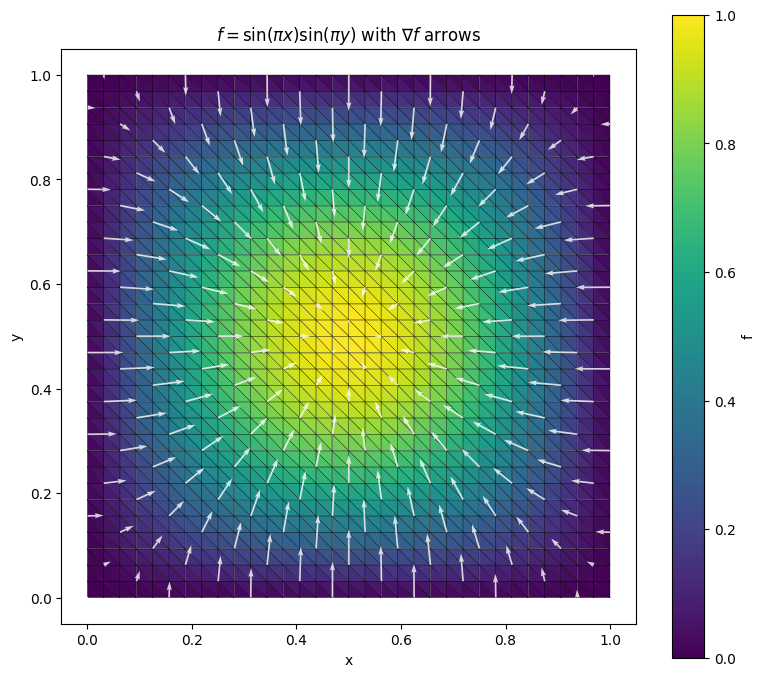

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the scalar field with gradient arrows overlaid
pts = mesh.points.numpy()
fig, ax = plt.subplots(figsize=(8, 7))
mesh.draw(point_scalars="f", backend="matplotlib", show=False, ax=ax)

# Subsample arrows for visual clarity
step = 5
points_np = mesh.points.detach().numpy()[::step]
grad_f_np = grad_f.detach().numpy()[::step]

ax.quiver(
    points_np[:, 0],
    points_np[:, 1],
    grad_f_np[:, 0],
    grad_f_np[:, 1],
    color="white",
    scale=50,
    width=0.003,
    alpha=0.8,
)
ax.set_title(r"$f = \sin(\pi x)\sin(\pi y)$ with $\nabla f$ arrows")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Gradients of Vector Fields (Jacobian)

For vector fields, the gradient is a matrix (the Jacobian).

In [33]:
# Create a vector field: v = [x*y, x^2]
# Jacobian: [[y, x], [2x, 0]]
mesh = unit_square.load(subdivisions=5)
x, y = mesh.points[:, 0], mesh.points[:, 1]
mesh.point_data["v"] = torch.stack([x * y, x**2], dim=-1)

# Compute Jacobian
mesh_with_jac = mesh.compute_point_derivatives(keys="v", method="lsq")
jacobian = mesh_with_jac.point_data["v_gradient"]

print(f"Jacobian shape: {jacobian.shape}  (n_points, n_output_dims, n_spatial_dims)")
print(f"\nJacobian at point (x=0.5, y=0.5):")
# Find point near (0.5, 0.5)
idx = ((mesh.points - torch.tensor([0.5, 0.5])).norm(dim=-1)).argmin()
print(f"  Location: {mesh.points[idx]}")
print(f"  Jacobian:\n{jacobian[idx]}")
print(f"  Expected: [[0.5, 0.5], [1.0, 0.0]]")

Jacobian shape: torch.Size([1089, 2, 2])  (n_points, n_output_dims, n_spatial_dims)

Jacobian at point (x=0.5, y=0.5):
  Location: tensor([0.5000, 0.5000])
  Jacobian:
tensor([[ 5.0000e-01,  5.0000e-01],
        [ 1.0000e+00, -3.0744e-08]])
  Expected: [[0.5, 0.5], [1.0, 0.0]]


### Computing Multiple Gradients at Once

You can compute gradients of multiple fields in a single call.

In [34]:
mesh = unit_square.load(subdivisions=5)
mesh.point_data["pressure"] = mesh.points[:, 0] ** 2 + mesh.points[:, 1] ** 2
mesh.point_data["temperature"] = torch.sin(math.pi * mesh.points[:, 0])

# Compute gradients of both fields
mesh_grad = mesh.compute_point_derivatives(keys=["pressure", "temperature"])

print("Computed gradient fields:")
for key in mesh_grad.point_data.keys():
    if "gradient" in key:
        print(f"  {key}: {mesh_grad.point_data[key].shape}")

Computed gradient fields:
  pressure_gradient: torch.Size([1089, 2])
  temperature_gradient: torch.Size([1089, 2])


### Autograd Compatibility

The LSQ gradient operator is built from standard differentiable PyTorch operations
(`torch.linalg.lstsq`), so it composes with autograd. This means you can compute
PDE residuals on mesh data produced by a neural network and backpropagate through
the calculus operators:

In [35]:
from physicsnemo.mesh.calculus import compute_gradient_points_lsq

mesh = unit_square.load(subdivisions=5)

# Simulate a model output: a scalar field with gradient tracking
field = torch.sin(mesh.points[:, 0]).detach().requires_grad_(True)

# Compute the spatial gradient - this is differentiable
grad_f = compute_gradient_points_lsq(mesh, field)

# Use in a loss function (e.g., PDE residual) and backpropagate
loss = grad_f.norm(dim=-1).mean()
loss.backward()

print(f"field.grad shape: {field.grad.shape}")
print(f"field.grad is not None: {field.grad is not None}")
print(f"Autograd flows through LSQ gradient computation")

field.grad shape: torch.Size([1089])
field.grad is not None: True
Autograd flows through LSQ gradient computation


## Section 2: Divergence

The divergence of a vector field measures the net "outflow" at each point.

For a 2D field v = [v_x, v_y]: div(v) = ∂v_x/∂x + ∂v_y/∂y

In [36]:
from physicsnemo.mesh.calculus import compute_divergence_points_lsq

# Create a vector field with known divergence
# v = [x, y] has divergence = 2 (constant)
mesh = unit_square.load(subdivisions=5)
velocity = mesh.points.clone()  # v = [x, y]

div_v = compute_divergence_points_lsq(mesh, velocity)

print(f"Divergence shape: {div_v.shape}")
print(f"Mean divergence: {div_v.mean():.4f} (expected: 2.0)")
print(f"Std divergence: {div_v.std():.6f}")

Divergence shape: torch.Size([1089])
Mean divergence: 2.0000 (expected: 2.0)
Std divergence: 0.000000


In [37]:
# A solenoidal (divergence-free) field
# v = [-y, x] is a rotation field with div = 0
mesh = unit_square.load(subdivisions=5)
x, y = mesh.points[:, 0], mesh.points[:, 1]
rotation_field = torch.stack([-y, x], dim=-1)

div_rotation = compute_divergence_points_lsq(mesh, rotation_field)
print(f"Divergence of rotation field: {div_rotation.mean():.6f} (expected: 0)")

Divergence of rotation field: -0.000000 (expected: 0)


## Section 3: Curl (3D Only)

The curl measures the "rotation" or "vorticity" of a vector field.

curl(v) = [∂v_z/∂y - ∂v_y/∂z, ∂v_x/∂z - ∂v_z/∂x, ∂v_y/∂x - ∂v_x/∂y]

Curl is only defined in 3D -- cross products are, quite interestingly, only well-defined in 3D and [7D](https://en.wikipedia.org/wiki/Seven-dimensional_cross_product).

In [38]:
from physicsnemo.mesh.calculus import compute_curl_points_lsq

# Create a 3D volume mesh (curl needs full 3D neighborhoods to recover all
# Jacobian entries; on a 2D surface the normal-direction derivatives are lost)
mesh = cube_volume.load(subdivisions=8)

# A rotation field around the z-axis: v = [-y, x, 0]
# Its curl is [0, 0, 2] (constant)
x, y, z = mesh.points[:, 0], mesh.points[:, 1], mesh.points[:, 2]
rotation_field = torch.stack([-y, x, torch.zeros_like(z)], dim=-1)

curl_v = compute_curl_points_lsq(mesh, rotation_field)

print(f"Curl shape: {curl_v.shape}")
print(f"Mean curl: {curl_v.mean(dim=0)} (expected: [0, 0, 2])")

Curl shape: torch.Size([729, 3])
Mean curl: tensor([-1.8164e-08,  6.3354e-09,  2.0000e+00]) (expected: [0, 0, 2])


## Section 4: Curvature

PhysicsNeMo-Mesh computes two types of curvature for surface meshes:

| Curvature | Formula | Properties |
|-----------|---------|------------|
| **Gaussian** (K) | K = κ₁ × κ₂ | Intrinsic, preserved under bending |
| **Mean** (H) | H = (κ₁ + κ₂) / 2 | Extrinsic, depends on embedding |

where κ₁ and κ₂ are the principal curvatures.

In [39]:
# For a sphere of radius r:
# - Gaussian curvature K = 1/r²
# - Mean curvature H = 1/r

radius = 2.0
sphere = sphere_icosahedral.load(radius=radius, subdivisions=4)

K = sphere.gaussian_curvature_vertices
H = sphere.mean_curvature_vertices

print(f"Sphere radius: {radius}")
print(f"\nGaussian curvature:")
print(f"  Expected: {1 / radius**2:.4f}")
print(f"  Mean computed: {K.mean():.4f}")
print(f"\nMean curvature:")
print(f"  Expected: {1 / radius:.4f}")
print(f"  Mean computed: {H.mean():.4f}")

Sphere radius: 2.0

Gaussian curvature:
  Expected: 0.2500
  Mean computed: 0.2503

Mean curvature:
  Expected: 0.5000
  Mean computed: 0.5000


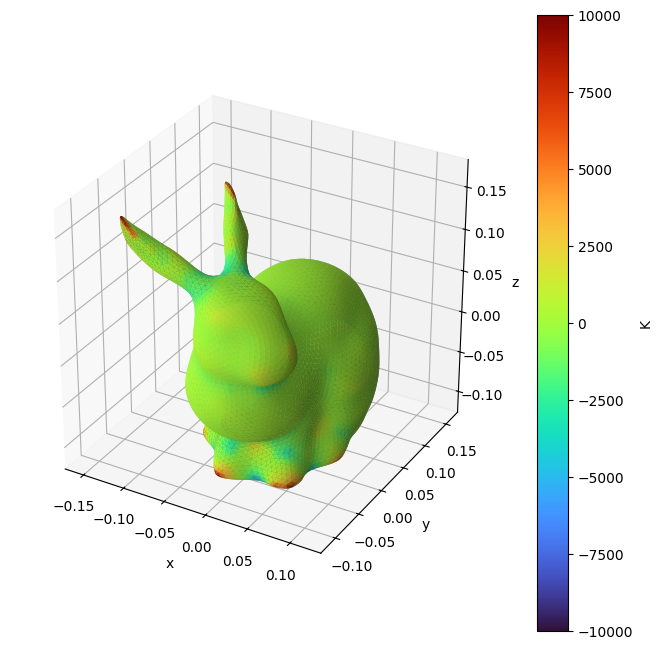

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [54]:
# Visualize curvature on the bunny
bunny = torch.load("assets/bunny.pt", weights_only=False).subdivide(2, "loop")

# Gaussian curvature: positive=convex (sphere-like), negative=saddle
bunny.point_data["K"] = bunny.gaussian_curvature_vertices
bunny.draw(
    point_scalars="K",
    cmap="turbo",
    show_edges=False,
    backend="matplotlib",
    vmin=-1e4,
    vmax=1e4,
)

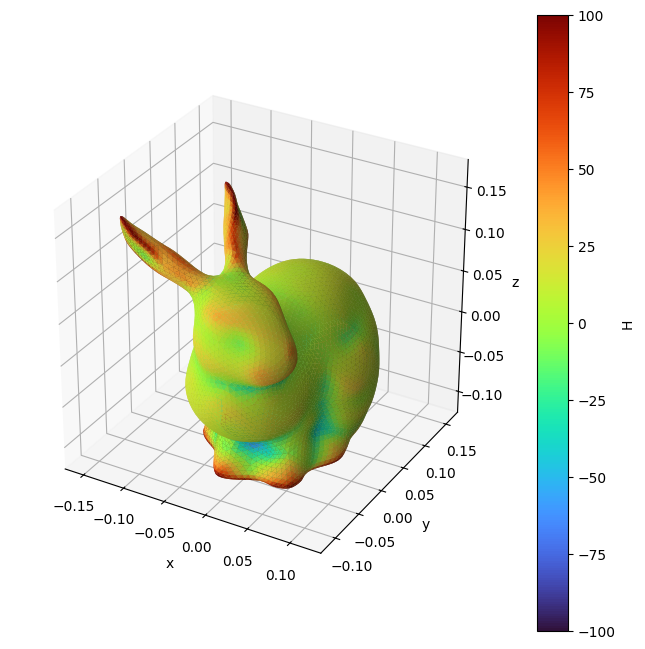

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [55]:
# Mean curvature: useful for detecting ridges and valleys
bunny.point_data["H"] = bunny.mean_curvature_vertices
bunny.draw(
    point_scalars="H",
    cmap="turbo",
    show_edges=False,
    backend="matplotlib",
    vmin=-100,
    vmax=100,
)

### Gauss-Bonnet Theorem

**Why this matters in practice:** The Gauss-Bonnet theorem provides a topological invariant
that must hold regardless of mesh resolution or deformation. This makes it useful for
**mesh validation** (if total curvature deviates from the expected value, something is wrong
with your mesh - inconsistent orientation, degenerate cells, missing faces) and for
**genus detection** (the total curvature immediately tells you how many handles the surface has).

The theorem relates total Gaussian curvature to topology:

$\int_M K \, dA = 2\pi \cdot \chi(M)$

where $\chi$ is the Euler characteristic. For a closed surface: $\chi = 2 - 2g$ (g = genus/handles).

- Sphere (g=0): $\chi = 2$, total $K = 4\pi$
- Torus (g=1): $\chi = 0$, total $K = 0$

In [42]:
from physicsnemo.mesh.geometry.dual_meshes import compute_dual_volumes_0

# Sphere: genus=0, χ=2, total K = 4π
sphere = sphere_icosahedral.load(subdivisions=4)
K = sphere.gaussian_curvature_vertices
dual_areas = compute_dual_volumes_0(sphere)
total_K = (K * dual_areas).sum()

print(f"Sphere (genus=0):")
print(f"  Expected total K: {4 * math.pi:.4f}")
print(f"  Computed total K: {total_K:.4f}")
print(f"  Error: {abs(total_K - 4 * math.pi):.6f}")

Sphere (genus=0):
  Expected total K: 12.5664
  Computed total K: 12.5669
  Error: 0.000483


In [43]:
# Torus: genus=1, χ=0, total K = 0
donut = torus.load(major_radius=1.0, minor_radius=0.3, n_major=64, n_minor=32)
K_torus = donut.gaussian_curvature_vertices
dual_areas_torus = compute_dual_volumes_0(donut)
total_K_torus = (K_torus * dual_areas_torus).sum()

print(f"Torus (genus=1):")
print(f"  Expected total K: 0.0")
print(f"  Computed total K: {total_K_torus:.6f}")

Torus (genus=1):
  Expected total K: 0.0
  Computed total K: 0.000353


## Section 5: Intrinsic vs Extrinsic Derivatives

For surfaces embedded in 3D, there are two types of derivatives:

| Type | Description | Use Case |
|------|-------------|----------|
| **Intrinsic** | Gradient in the tangent plane | Surface PDEs, physics on manifolds |
| **Extrinsic** | Gradient in ambient 3D space | Feature extraction, ambient flow |

Intrinsic gradients are perpendicular to the surface normal.

In [44]:
# Create a sphere with a scalar field based on z-coordinate
sphere = sphere_icosahedral.load(subdivisions=3)
sphere.point_data["height"] = sphere.points[:, 2]

# Compute intrinsic gradient (in tangent space)
sphere_intrinsic = sphere.compute_point_derivatives(
    keys="height", method="lsq", gradient_type="intrinsic"
)
grad_intrinsic = sphere_intrinsic.point_data["height_gradient"]

# Compute extrinsic gradient (in ambient space)
sphere_extrinsic = sphere.compute_point_derivatives(
    keys="height", method="lsq", gradient_type="extrinsic"
)
grad_extrinsic = sphere_extrinsic.point_data["height_gradient"]

print(f"Intrinsic gradient shape: {grad_intrinsic.shape}")
print(f"Extrinsic gradient shape: {grad_extrinsic.shape}")

Intrinsic gradient shape: torch.Size([642, 3])
Extrinsic gradient shape: torch.Size([642, 3])


In [45]:
# Verify: intrinsic gradient should be perpendicular to surface normal
normals = sphere.point_normals  # (n_points, 3)

# Dot product of gradient with normal should be ~0 for intrinsic
dot_intrinsic = (grad_intrinsic * normals).sum(dim=-1)
dot_extrinsic = (grad_extrinsic * normals).sum(dim=-1)

print(f"Intrinsic gradient · normal: {dot_intrinsic.abs().mean():.6f} (should be ~0)")
print(f"Extrinsic gradient · normal: {dot_extrinsic.abs().mean():.4f} (non-zero)")

Intrinsic gradient · normal: 0.000000 (should be ~0)
Extrinsic gradient · normal: 0.4985 (non-zero)


Intrinsic gradient magnitude (tangent to surface):


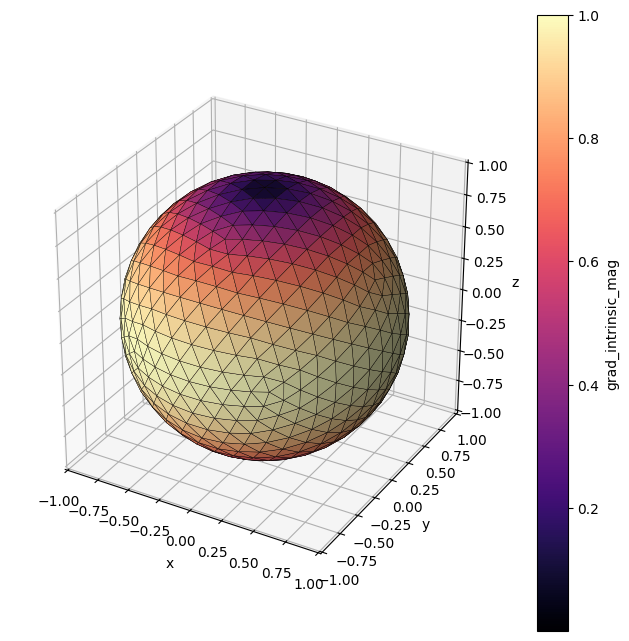

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [46]:
# Visualize the difference: intrinsic gradient magnitude
sphere.point_data["grad_intrinsic_mag"] = grad_intrinsic.norm(dim=-1)
sphere.point_data["grad_extrinsic_mag"] = grad_extrinsic.norm(dim=-1)

print("Intrinsic gradient magnitude (tangent to surface):")
sphere.draw(point_scalars="grad_intrinsic_mag", cmap="magma", backend="matplotlib")

Extrinsic gradient magnitude (includes normal component):


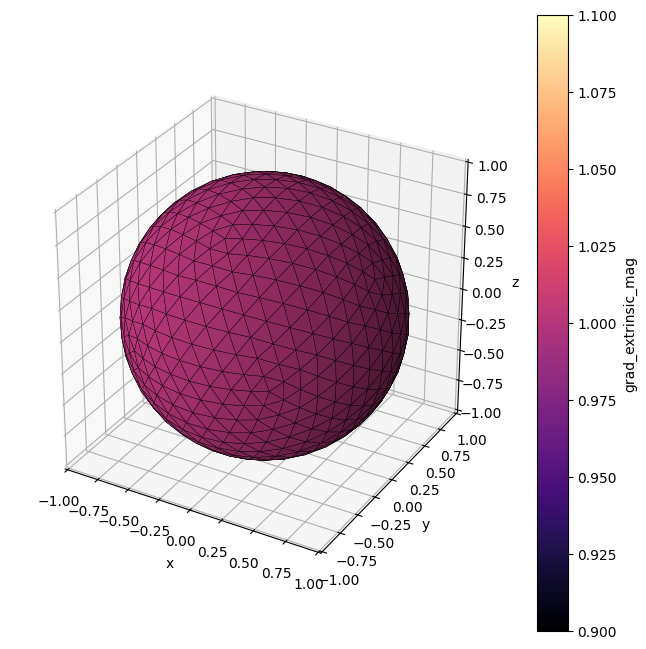

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [47]:
print("Extrinsic gradient magnitude (includes normal component):")
sphere.draw(
    point_scalars="grad_extrinsic_mag",
    cmap="magma",
    backend="matplotlib",
    vmin=0.9,
    vmax=1.1,
)

The intrinsic gradient is largest at the equator (where height changes most rapidly
*along the surface*) and zero at the poles (where the surface is perpendicular to the
z-axis, so there's no tangential component). The extrinsic gradient includes the normal
component, giving a non-zero contribution everywhere - it points straight up in 3D
space at every point, since height = z has constant extrinsic gradient [0, 0, 1].

## Section 6: Vector Calculus Identities

The discrete operators satisfy the fundamental vector calculus identities:

- $\nabla \times (\nabla f) = \mathbf{0}$ : The curl of any gradient field is identically zero
- $\nabla \cdot (\nabla \times \mathbf{v}) = 0$ : The divergence of any curl field is identically zero

Let's verify these numerically.

In [48]:
from physicsnemo.mesh.calculus import compute_gradient_points_lsq
from physicsnemo.mesh.calculus import compute_curl_points_lsq
from physicsnemo.mesh.calculus import compute_divergence_points_lsq

# Create a 3D mesh (surface in 3D)
mesh = sphere_icosahedral.load(subdivisions=4)

# Scalar field: f = x² + y² + z²
f = (mesh.points**2).sum(dim=-1)

# Compute gradient
grad_f = compute_gradient_points_lsq(mesh, f)
print(f"grad(f) shape: {grad_f.shape}")

# Compute curl of gradient
curl_grad_f = compute_curl_points_lsq(mesh, grad_f)
print(f"curl(grad(f)) shape: {curl_grad_f.shape}")

# Should be approximately zero
print(f"\n|curl(grad(f))| mean: {curl_grad_f.norm(dim=-1).mean():.6f}")
print(f"|curl(grad(f))| max: {curl_grad_f.norm(dim=-1).max():.6f}")

grad(f) shape: torch.Size([2562, 3])
curl(grad(f)) shape: torch.Size([2562, 3])

|curl(grad(f))| mean: 0.000215
|curl(grad(f))| max: 0.000712


In [49]:
# div(curl(v)) = 0
# Create a vector field
v = mesh.points.clone()  # v = [x, y, z]

# Compute curl
curl_v = compute_curl_points_lsq(mesh, v)

# Compute divergence of curl
div_curl_v = compute_divergence_points_lsq(mesh, curl_v)

print(f"div(curl(v)) mean: {div_curl_v.mean():.6f}")
print(f"div(curl(v)) max: {div_curl_v.abs().max():.6f}")

div(curl(v)) mean: -0.000000
div(curl(v)) max: 0.000102


## Section 7: Worked Example - Calculus on a Nontrivial Field

Let's tie everything together with a realistic example: defining a physically meaningful
scalar field on the bunny mesh, computing its derivatives, and visualizing the results.
This demonstrates the kind of feature engineering that feeds into physics-informed models.

Pressure field on the bunny:


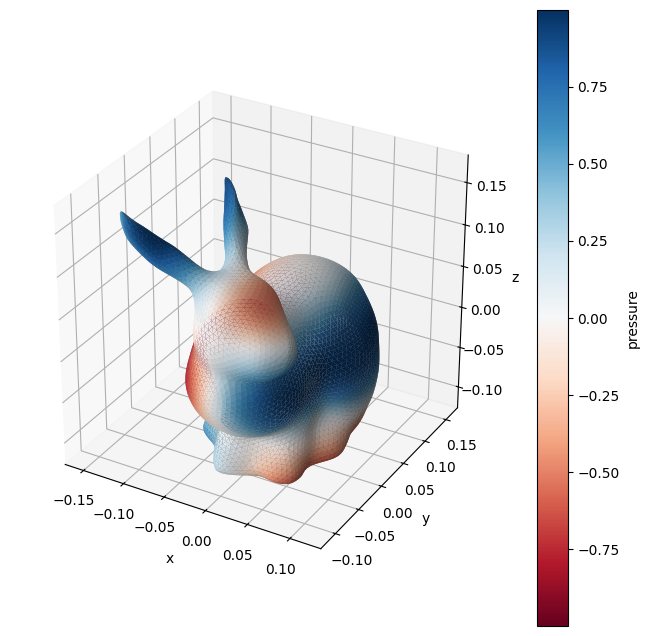

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [50]:
# Load the bunny and define a "pressure wave" - a smooth oscillating field
# that varies in both x and z, producing interesting spatial gradients
bunny = torch.load("assets/bunny.pt", weights_only=False).subdivide(2, "loop")
x, y, z = bunny.points[:, 0], bunny.points[:, 1], bunny.points[:, 2]

# Oscillating pressure field: ~2 full oscillations across the mesh
k = 20.0
bunny.point_data["pressure"] = torch.sin(k * x) * torch.cos(k * z)

print("Pressure field on the bunny:")
bunny.draw(
    point_scalars="pressure", cmap="RdBu", show_edges=False, backend="matplotlib"
)

Pressure gradient magnitude (high = rapid spatial change):


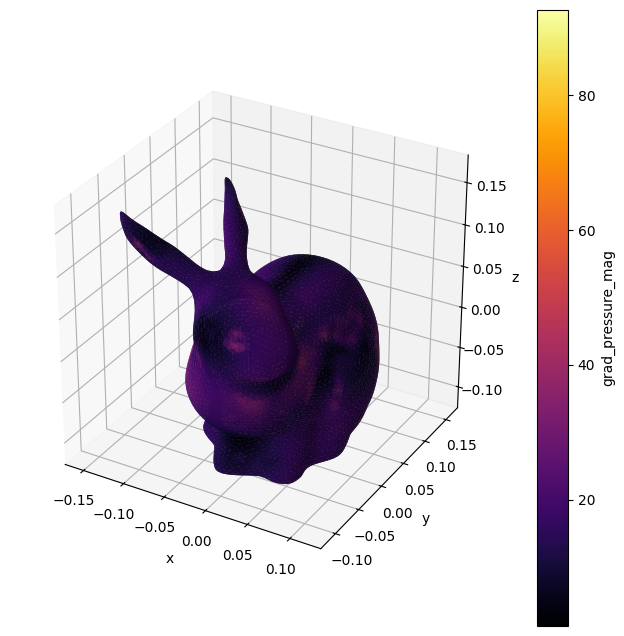

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [51]:
# Compute the pressure gradient and visualize its magnitude
# (where is pressure changing fastest?)
grad_p = compute_gradient_points_lsq(bunny, bunny.point_data["pressure"])
bunny.point_data["grad_pressure_mag"] = grad_p.norm(dim=-1)

print("Pressure gradient magnitude (high = rapid spatial change):")
bunny.draw(
    point_scalars="grad_pressure_mag",
    cmap="inferno",
    show_edges=False,
    backend="matplotlib",
)

In [52]:
# Combine field derivatives with geometric features for a full feature set
bunny.point_data["gaussian_curvature"] = bunny.gaussian_curvature_vertices
bunny.point_data["mean_curvature"] = bunny.mean_curvature_vertices
bunny.point_data["normal"] = bunny.point_normals

# Compute the full Jacobian of pressure as well
bunny = bunny.compute_point_derivatives(keys="pressure", method="lsq")

print("Full feature set for a physics-informed model:")
for key in sorted(bunny.point_data.keys()):
    shape = bunny.point_data[key].shape
    trailing = shape[1:] if len(shape) > 1 else "(scalar)"
    print(f"  {key:30s} {str(trailing):>15s}")

Full feature set for a physics-informed model:
  _cache                                (scalar)
  gaussian_curvature                    (scalar)
  grad_pressure_mag                     (scalar)
  mean_curvature                        (scalar)
  normal                         torch.Size([3])
  pressure                              (scalar)
  pressure_gradient              torch.Size([3])


The gradient magnitude plot reveals where the pressure field varies most rapidly. Combined
with geometric features like curvature and normals, these form a rich per-vertex feature
vector for downstream ML models - all computed on the GPU in a single differentiable pass.

## Summary

In this tutorial, you learned about discrete calculus on meshes:

1. **Gradients**: `compute_point_derivatives()` for scalar and vector fields
2. **Divergence**: `compute_divergence_points_lsq()` for vector fields
3. **Curl**: `compute_curl_points_lsq()` for 3D vector fields
4. **Curvature**: `gaussian_curvature_vertices`, `mean_curvature_vertices`
5. **Intrinsic vs Extrinsic**: `gradient_type="intrinsic"` for surface PDEs
6. **Identities**: curl(grad(f)) = 0, div(curl(v)) = 0